# Unsupervised Modeling of Reviews
<p style='color:navy'><b>
    In this section, we ignore the <i> A Priori</i> classes that our review dataset belongs to and 
    created two unsupervised models - LDA and NMF - and see how the clusters we generated compare 
    to the classes the data belongs to.
</b></p>

## Table of Contents
<ol>
    <li>Packages</li>
    <li>Parquet Ingestion</li>
    <li>Data Preparation</li>
    <li><b>NMF</b> - Non-negative matrix factorization</li>
    <li><b>NMF</b> - Rebalanced Dataset</li>
    <li><b>NMF</b> - Rebalanced Dataset with Adjectives/Verbs only</li>
    <li><b>NMF</b> - Evaluating topic performance</li>
    <li><b>LDA</b> - Latent Dirichlet Allocation</li>
</ol>

### Packages

In [1]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import NMF
from collections import Counter, defaultdict
import warnings #turn off warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Parquet Ingestion

In [2]:
df = pd.read_parquet('prepared_text.parquet.gzip')

In [3]:
df = df.rename({"new_reviews":"text"},axis=1)
df.sample(3)

,Rating,text,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities,tokens
344035,5,excelente,[excelente],[],[excelente],[],[],[],[excelente]
403103,3,especifican si hay en español,"[especifican, si, hay, en, español]",[],"[especifican, si, hay, español]",[],[],[especifican_si/ORG],"[especifican, si, hay, en, español]"
294176,1,return window closed nov 21 whitch yesterday p...,"[return, window, close, nov, 21, whitch, yeste...","[close, die, love]","[return, window, nov, whitch, yesterday, phone...","[whitch_yesterday, whitch_yesterday_phone, yes...",[],[],"[return, window, closed, nov, 21, whitch, yest..."


as a result of our data cleaning pipeline, much of the groundwork needed for unsupervised analysis has already been laid out for us, primarily in the realm of tokenization. Based on the performance of our LDA and NMF models, we may consider modifying the text we pass to either model by omitting certain parts of speech or entities to improve model performance. 

### Preparation
All unsupervised and supervised learning needs vectorized documents, so we start with the TF-IDF and remove stop words (most of which have been eliminated already) to create a sparse matrix for the text. 

In [ ]:
tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df['text'])
vectors_text.shape

### Nonnegative Matrix Factorization (NMF)
The easiest way to find a latent structure in a doc matrix is by factorizing it and seeing what's left over. Because a TFIDF matrix always has positive values, we can represent a document matrix as the product of two smaller matrices: V = W * H, where **W has the same number of rows as V and represent the topic mapping for each document, and H shows how the topics are constituted of features.**

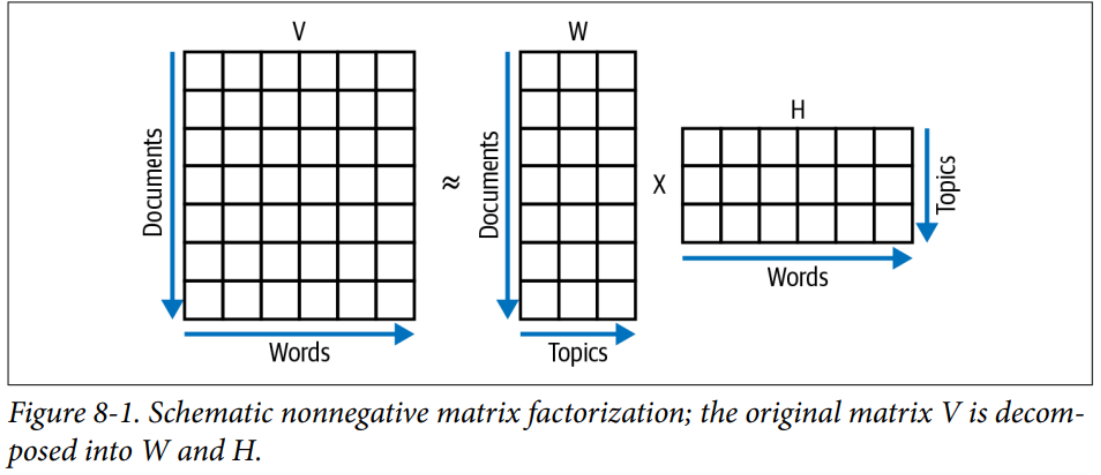

we begin by declaring an NMF object with five components - this lines up with the number of possible review scores we could expect to find in our dataset and then fit it to our sparse matrix:

In [ ]:
nmf_text_model = NMF(n_components=5, random_state=78)
W_text_matrix_0 = nmf_text_model.fit_transform(vectors_text)
H_text_matrix_0 = nmf_text_model.components_

Next, we need some functionality for digging into each topic:

In [ ]:
#we can create a function that shows us each topic and what words(features) contribute to each one.
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        
        print("\nTopic %02d" % topic)
        
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
            word_vector[largest[i]]*100.0/total))

In [ ]:
display_topics(nmf_text_model, tfidf_text.get_feature_names_out())

On face value, our NMF has produced five categories which all seem to lean towards positive reviews, except for topic 04, which seems to be driven by reviews in other languages. This is probably because of the fact that positive reviews are heavily oversampled.

In [ ]:
df['Rating'].value_counts().sort_values().plot(kind='bar')
plt.title("Distribution of Reviews")
plt.show()

therefore, we can consider undersampling 5-star reviews and oversampling other reviews to get a better representation and run our NMF one more time:

### NMF Recalculation with balanced dataset

In [ ]:
#create a resampled dataframe where five-star reviews have been sampled down to n=70k
five_stars = df[df['Rating'] == 5].sample(n=70000)
non_five = df[df['Rating'] != 5 ]
df_bal = pd.concat([five_stars,non_five],axis=0)

In [ ]:
#resample the entire data frame so that some reviews are oversampled
ros = RandomOverSampler(random_state=0)
#reshape our text series to fit into our oversampler - we undo this later by flattening it.
X = df_bal[['text','adjs_verbs']]#.values.reshape(-1,1) 
y = df_bal['Rating']
ros.fit(
    X,y
)
X_resampled, y_resampled = ros.fit_resample(X, y)
df_bal = X_resampled
df_bal['Rating'] = y_resampled

In [ ]:
df_bal.head()

In [ ]:
# review out distribution!
df_bal['Rating'].value_counts().sort_values().plot(kind='bar')
plt.title("Distribution of Reviews, Resampled")
plt.show()

In [ ]:
#revectorize everything and run our NMF 
tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df_bal['text'])

nmf_bal = NMF(n_components=5, random_state=78)
W_text_matrix_1 = nmf_bal.fit_transform(vectors_text)
H_text_matrix_1 = nmf_bal.components_

display_topics(nmf_bal, tfidf_text.get_feature_names_out())

Our clusters seem to be driven by a variation in the use certain adjectives - the use of the words good, great, excellent, and ok seem to align with expectations in the difference of sentiment between reviews. However, the fact that topic 1 is motivated by the word "phone" presents an issue with using nouns for clustering. We may try one final approach by *only* looking at adjectives and verbs.

### NMF Calculation with Rebalanced Dataset and verbs/adjectives only

to make adjective-and-verb-only analysis feasible, we need a function that will create a new text column by concatenating the elements of our ```adj_verbs``` feature:

In [ ]:
df_bal['text_adjs'] = df_bal['adjs_verbs'].apply(lambda x: " ".join(x))
df_bal.head()

In [ ]:
#revectorize everything and run our NMF 
tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df_bal['text_adjs'])

nmf_bal = NMF(n_components=5, random_state=78)
W_text_matrix_2 = nmf_bal.fit_transform(vectors_text)
H_text_matrix_2 = nmf_bal.components_

display_topics(nmf_bal, tfidf_text.get_feature_names_out())

Our new clusters seem to be slightly more intuitive - Topic 00 could be lined to a rating of 3, while topics 4 and 1 could be ratings 5 and 4, respectively. Topic 2 seems like it could be a negative review cluster.

### Evaluating Cluster Performance for NMF Models on Balanced Dataset

the first step to comparing clusters with our a priori labels is to determine what group each document is primarily a member of, which we can do by accessing the W matrix, which contains a list of membership scores for each document, sequentially, from cluster 0 to cluster 4.

In [ ]:
W_text_matrix_1[0:1].tolist()

In order to approximate the cluster assigned to each document, we develop a function that returns the index of the highest value:

In [ ]:
#accepts an np array object with shape(N,x>1)
def clusterFit(w):
    
    if type(w) != list:
        w = w.tolist()
    #this operation collapses the multidimensional list into a 1D list of values
    # [a,b,c,d,e] ==> [max(a,b,c,d,e)]
    for i in range(0,len(w)):
        w[i] = w[i].index(max(w[i]))
    
    return(w)

In [ ]:
#add to our dataframe:
df_bal['text_NMF'] = clusterFit(W_text_matrix_1)
df_bal['adj_NMF'] = clusterFit(W_text_matrix_2)
df_bal.head()

In an ideal world, each NMF cluster would be entirely homogenous as it would have a 1:1 correspondence to some review rating. A good way to measure how well our clusters conform to the apriori groups is by seeing how many of each rating fall into each topic. Furthermore, even if we fail to satisfy a purity test, we would at least expect each star rating to be dominant in exactly one topic to claim some level of success:

#### Purity of Full-Text NMF Clustering

In [ ]:
for i in range(0,5):
    this_topic = df_bal.groupby('text_NMF')['Rating'].value_counts()[i]
    this_ratio = this_topic / this_topic.sum()
    print(this_ratio)

#### Purity of Adjective/Verb NMF Clustering

In [ ]:
for i in range(0,5):
    this_topic = df_bal.groupby('adj_NMF')['Rating'].value_counts()[i]
    this_ratio = this_topic / this_topic.sum()
    print(this_ratio)

In conclusion, our adjective NMF didn't produce very homogenous topics - the highest score across all of these belongs to ratings in the 1,4, or 5 category, which means 2 and 3 star ratings aren't particularly well represented by any topic. 

However, the full-text NMF gets slightly closer to our goal of representation - ratings 1,4,5, and 3 all have a high score in at least one topic, meaning that we only fail to give dominance to 2-star ratings.

### Latent Dirichlet Allocation
LDA views each document as consisting of different topics. In other words, each
document is a mix of different topics. In the same way, topics are mixed from words.
To keep the number of topics per document low and to have only a few, important
words constituting the topics, LDA initially uses a Dirichlet distribution, a so-called
Dirichlet prior. This is applied both for assigning topics to documents and for finding
words for the topics. The Dirichlet distribution ensures that documents have only a
small number of topics and topics are mainly defined by a small number of words.

### Approach 1: Full Text LDA

In [ ]:
#create a vectorizer and fit it with our df
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(df["text"])

#create our W and H matrices
lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [ ]:
#load our LDA topics
display_topics(lda_para_model, tfidf_para_vectorizer.get_feature_names())